The code below colors each residue in an MSA by its pLDDT score.

In [ ]:
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import io
import os
import base64
import sys
import json
import glob
import numpy as np

def color_alignment(fasta_file, actives, output_file):
    # Read the FASTA file
    records = list(SeqIO.parse(fasta_file, "fasta"))
    full_alignment_length = len(records[0].seq)

    # Color map for different value ranges
    cmap = {
        "orange": {"facecolor": "orange", "condition": lambda x: x < 50},
        "yellow": {"facecolor": "yellow", "condition": lambda x: 50 <= x < 70},
        "cyan": {"facecolor": "cyan", "condition": lambda x: 70 <= x < 90},
        "cornflowerblue": {"facecolor": "cornflowerblue", "condition": lambda x: x >= 90}
    }

    # Create a color map for each residue in each sequence
    colors = []
    for i in range(len(records)):
        seq_colors = []

        # Get the sequence name
        sequence_name = records[i].description.split("/")[0].lower()

        # Find the JSON file for the sequence using glob
        json_file = glob.glob(f"{sequence_name}_4x2/{sequence_name}_4x2_scores_rank_001_*.json")[0]
        with open(json_file) as f:
            print('loading ', json_file)
            data = json.load(f)
            values = data.get("plddt", [])

        # Exclude gaps from the alignment sequence
        alignment_sequence = str(records[i].seq).replace("-", "")
        alignment_length = len(alignment_sequence)

        if len(values) < alignment_length:
            print(f"Warning: Insufficient pLDDT values for sequence {i+1}. "
                  f"Using available values and white color for gaps.")
            values.extend([None] * (full_alignment_length - len(values)))

        for j, residue in enumerate(records[i].seq):
            if residue == "-":
                if sequence_name in actives:
                    seq_colors.append("silver") # Set gap color to light gray for 'actives'
                else:
                    seq_colors.append("white") # Set gap color to white for non-'actives'
            else:
                residue_value = values[j]
                for color, color_values in cmap.items():
                    if color_values["condition"](residue_value):
                        seq_colors.append(color_values["facecolor"])
                        break
        colors.append(seq_colors)

    # Determine the longest label length
    max_label_len = max(len(record.description) for record in records)

    # Set the figure size and padding based on the label length
    fig_height = len(records) * 0.25
    fig_width = len(records[0].seq) * 0.21 + max_label_len * 0.03  # Adjust the padding based on label length
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=150)  # Adjust the DPI value

    # Add left padding to the plot
    pad_left = max_label_len * 0.03
    ax.set_xlim(0.5, len(records[0].seq) + 0.5)  # Adjust x-axis limits
    ax.set_ylim(-0.5, len(records) - 0.5)  # Adjust y-axis limits

    # Remove the y-axis tick marks and labels
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.NullLocator())

    # Iterate over the sequences and residues to plot the alignment
    for i, record in enumerate(records):
        sequence_name = record.description.split("/")[0].lower()

        if sequence_name in actives:
            ax.text(-pad_left, i, sequence_name, ha='right', va='center', fontweight='bold', fontsize=10)
        else:
            ax.text(-pad_left, i, sequence_name, ha='right', va='center', fontweight='normal', fontsize=10)

        for j, residue in enumerate(record.seq):
            color = colors[i][j]

            rect = plt.Rectangle((j + 0.5, i - 0.5), 1, 1, facecolor=color, edgecolor='none')

            # Add a transparent silver background for sequences in the 'actives' list
            if sequence_name in actives:
                if residue == "-":
                    rect_bg = plt.Rectangle((j + 0.5, i - 0.5), 1, 1, facecolor='silver', edgecolor='none', alpha=0.3)
                    ax.add_patch(rect_bg)
                else:
                    ax.add_patch(rect)
                ax.text(j + 1, i, residue, ha='center', va='center', fontweight='bold', fontsize=12)
            else:
                ax.add_patch(rect)
                ax.text(j + 1, i, residue, ha='center', va='center', fontweight='normal', fontsize=12)

    # Add minor ticks to the x-axis
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    plt.gca().invert_yaxis()
    ax.xaxis.set_ticks_position("top")
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    # Add a vertical line to show the cleavage site between the alpha and beta chains.
    ax.axvline(x=643.5, color='black', linestyle='-', linewidth=1)

    # Save the plot as a PNG image
    png_output_file = os.path.splitext(output_file)[0] + ".png"
    plt.savefig(png_output_file, dpi=150)  # Adjust the DPI value

    # Encode the image as base64
    with open(png_output_file, "rb") as f:
        img_data = base64.b64encode(f.read()).decode('utf-8')

    # Generate the HTML output
    #html = f'<html><body><img src="data:image/png;base64,{img_data}" /></body></html>'
    html = f'<html><body><div style="position: absolute; top: 0; left: 0;"><img src="data:image/png;base64,{img_data}" /></div></body></html>'

    # Save the HTML output to a file
    with open(output_file, 'w') as f:
        f.write(html)

# MAIN
fasta_file = "nylc_diversity_panel.mafft.fasta"
actives = ["nylc", "nyl4", "nyl10", "nyl11", "nyl12", "nyl13", "nyl14", 
           "nyl15", "nyl16", "nyl18", "nyl25", "nyl30", "nyl32", "nyl37",
           "nyl40", "nyl41", "nyl45", "nyl47", "nyl48", "nyl50", "nyl68",
           "nyl71", "nyl73", "nyl74", "nyl76", "nyl77", "nyl80", "nyl82",
           "nyl85", "nyl87", "nyl88", "nyl92", "nyl94"]
output_file = "nylc_diversity_panel.mafft_alignment_colored_by_plddt_20230603_jmp.html"
color_alignment(fasta_file, actives, output_file)


The code below reads an MSA in fasta format, removes all gaps, sorts the sequences
by length (shortest to longest), and colors each residue by its pLDDT score from AlphaFold.

loading  nyl10_4x2/nyl10_4x2_scores_rank_001_alphafold2_multimer_v3_model_2_seed_000.json
loading  nyl47_4x2/nyl47_4x2_scores_rank_001_alphafold2_multimer_v3_model_2_seed_000.json
loading  nyl63_4x2/nyl63_4x2_scores_rank_001_alphafold2_multimer_v3_model_3_seed_000.json
loading  nyl72_4x2/nyl72_4x2_scores_rank_001_alphafold2_multimer_v3_model_1_seed_000.json
loading  nyl29_4x2/nyl29_4x2_scores_rank_001_alphafold2_multimer_v3_model_3_seed_000.json
loading  nyl85_4x2/nyl85_4x2_scores_rank_001_alphafold2_multimer_v3_model_1_seed_000.json
loading  nyl34_4x2/nyl34_4x2_scores_rank_001_alphafold2_multimer_v3_model_3_seed_000.json
loading  nyl50_4x2/nyl50_4x2_scores_rank_001_alphafold2_multimer_v3_model_4_seed_000.json
loading  nyl52_4x2/nyl52_4x2_scores_rank_001_alphafold2_multimer_v3_model_3_seed_000.json
loading  nyl37_4x2/nyl37_4x2_scores_rank_001_alphafold2_multimer_v3_model_1_seed_000.json
loading  nyl68_4x2/nyl68_4x2_scores_rank_001_alphafold2_multimer_v3_model_5_seed_000.json
loading  n

loading  nyl51_4x2/nyl51_4x2_scores_rank_001_alphafold2_multimer_v3_model_4_seed_000.json
loading  nyl35_4x2/nyl35_4x2_scores_rank_001_alphafold2_multimer_v3_model_5_seed_000.json
loading  nyl26_4x2/nyl26_4x2_scores_rank_001_alphafold2_multimer_v3_model_5_seed_000.json
loading  nyl49_4x2/nyl49_4x2_scores_rank_001_alphafold2_multimer_v3_model_3_seed_000.json


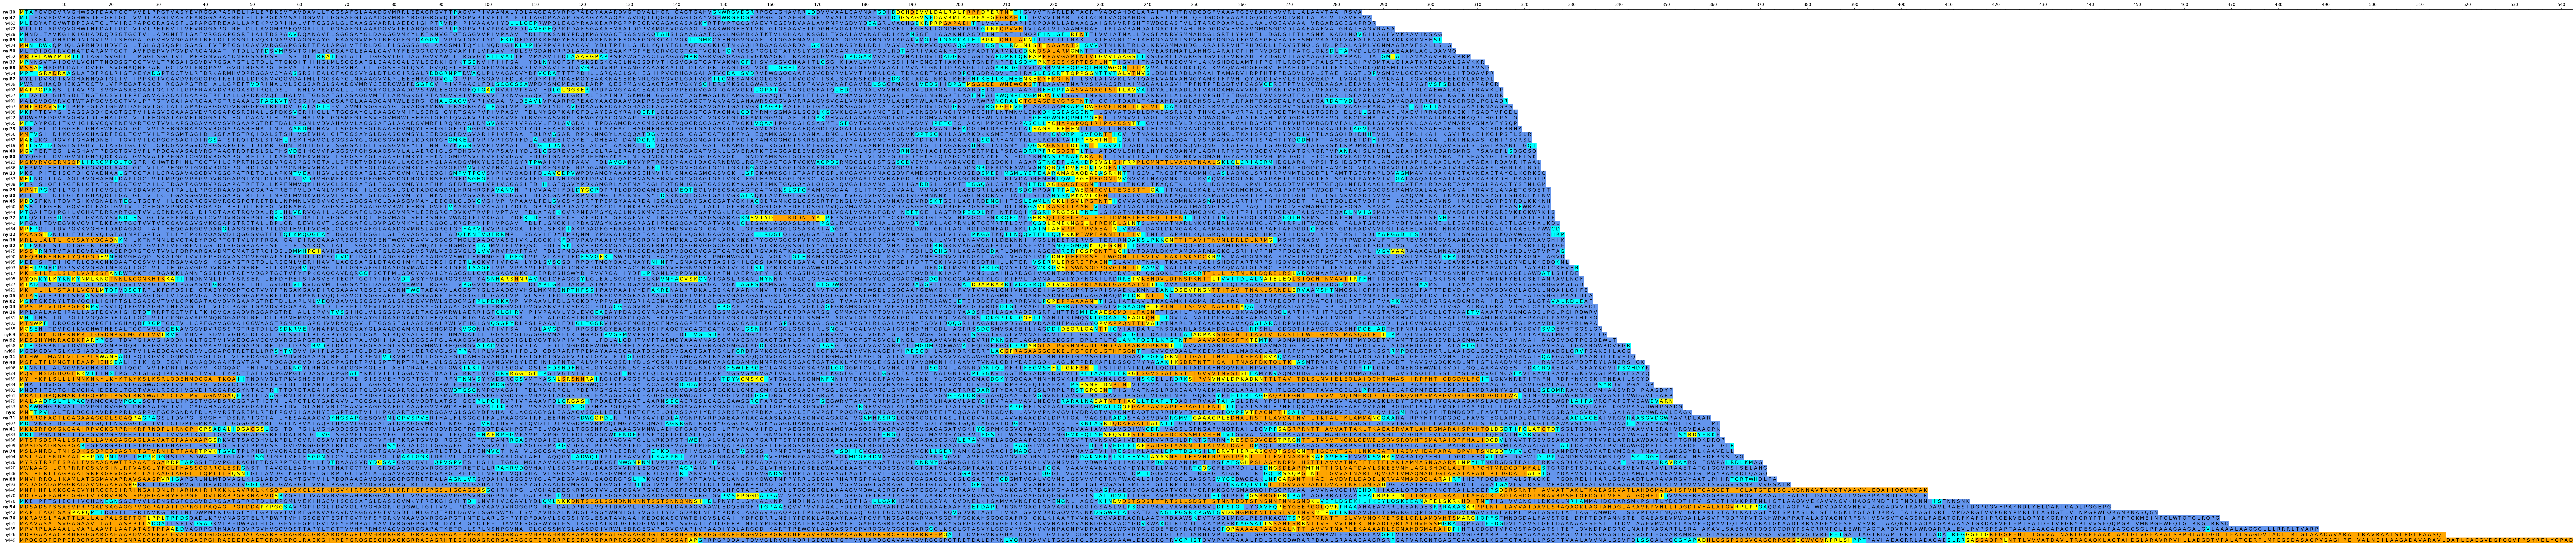

In [7]:
def sort_seqs_by_length_and_color_by_plddt(fasta_file, actives, output_file):
    # Read the FASTA file
    records = list(SeqIO.parse(fasta_file, "fasta"))

    # Remove gaps from the sequences
    records = [record.__class__(record.seq.ungap("-"), id=record.id, 
                                description=record.description) for record in records]

    # Sort the sequences by length in ascending order
    records.sort(key=lambda x: len(x.seq), reverse=False)

    # Color map for different value ranges
    cmap = {
        "orange": {"facecolor": "orange", "condition": lambda x: x < 50},
        "yellow": {"facecolor": "yellow", "condition": lambda x: 50 <= x < 70},
        "cyan": {"facecolor": "cyan", "condition": lambda x: 70 <= x < 90},
        "cornflowerblue": {"facecolor": "cornflowerblue", "condition": lambda x: x >= 90},
    }

    # Create a color map for each residue in each sequence
    colors = []
    for i in range(len(records)):
        seq_colors = []

        # Get the sequence name
        sequence_name = records[i].description.split("/")[0].lower()

        # Find the JSON file for the sequence using glob
        json_file = glob.glob(f"{sequence_name}_4x2/{sequence_name}_4x2_scores_rank_001_*.json")[0]
        with open(json_file) as f:
            print("loading ", json_file)
            data = json.load(f)
            values = data.get("plddt", [])

        ungapped_sequence = str(records[i].seq).replace("-", "")
        alignment_length = len(ungapped_sequence)

        for j, residue in enumerate(ungapped_sequence):
            residue_value = values[j]
            for color, color_values in cmap.items():
                if color_values["condition"](residue_value):
                    seq_colors.append(color_values["facecolor"])
                    break
        colors.append(seq_colors)

    # Determine the longest label length
    max_label_len = max(len(record.description) for record in records)

    # Set the figure size and padding based on the label length
    fig_height = len(records) * 0.25
    fig_width = (alignment_length * 0.21 + max_label_len * 0.03)  # Adjust the padding based on label length
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=150)  # Adjust the DPI value

    # Add left padding to the plot
    pad_left = max_label_len * 0.03
    ax.set_xlim(0.5, alignment_length + 0.5)  # Adjust x-axis limits
    ax.set_ylim(-0.5, len(records) - 0.5)  # Adjust y-axis limits

    # Remove the y-axis tick marks and labels
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.NullLocator())

    # Iterate over the sequences and residues to plot the alignment
    for i, record in enumerate(records):
        sequence_name = record.description.split("/")[0].lower()

        if sequence_name in actives:
            ax.text(-pad_left, i, sequence_name, ha="right", va="center", fontweight="bold", fontsize=10)
        else:
            ax.text(-pad_left, i, sequence_name, ha="right", va="center", fontweight="normal", fontsize=10)

        ungapped_sequence = str(record.seq).replace("-", "")
        for j, residue in enumerate(ungapped_sequence):
            if j >= len(colors[i]):
                break

            color = colors[i][j]
            rect = plt.Rectangle((j + 0.5, i - 0.5), 1, 1, facecolor=color, edgecolor="none")
            ax.add_patch(rect)
            ax.text(j + 1, i, residue, ha="center", va="center", fontweight="normal", fontsize=12)

    # Add minor ticks to the x-axis
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    plt.gca().invert_yaxis()
    ax.xaxis.set_ticks_position("top")
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    # Save the plot as a PNG image
    png_output_file = os.path.splitext(output_file)[0] + ".png"
    plt.savefig(png_output_file, dpi=150)  # Adjust the DPI value

    # Encode the image as base64
    with open(png_output_file, "rb") as f:
        img_data = base64.b64encode(f.read()).decode("utf-8")

    # Generate the HTML output
    html = f'<html><body><div style="position: absolute; top: 0; left: 0;"><img src="data:image/png;base64,{img_data}" /></div></body></html>'

    # Save the HTML output to a file
    with open(output_file, "w") as f:
        f.write(html)

# Example usage
fasta_file = "nylc_diversity_panel.mafft.fasta"
actives = ["nylc", "nyl4", "nyl10", "nyl11", "nyl12", "nyl13", "nyl14", "nyl15", "nyl16", "nyl18",
           "nyl25", "nyl30", "nyl32", "nyl37", "nyl40", "nyl41", "nyl45", "nyl47", "nyl48", "nyl50",
           "nyl68", "nyl71", "nyl73", "nyl74", "nyl76", "nyl77", "nyl80", "nyl82", "nyl85", "nyl87",
           "nyl88", "nyl92", "nyl94"]

output_file = "nylc_diversity_panel.sort_seqs_by_length_and_color_by_plddt_20230603_jmp.html"
sort_seqs_by_length_and_color_by_plddt(fasta_file, actives, output_file)


The code below reads an MSA in fasta format and generates a plot of the
sequences sorted by sequence length and colored by experimentally measured
enzymatic activity. 

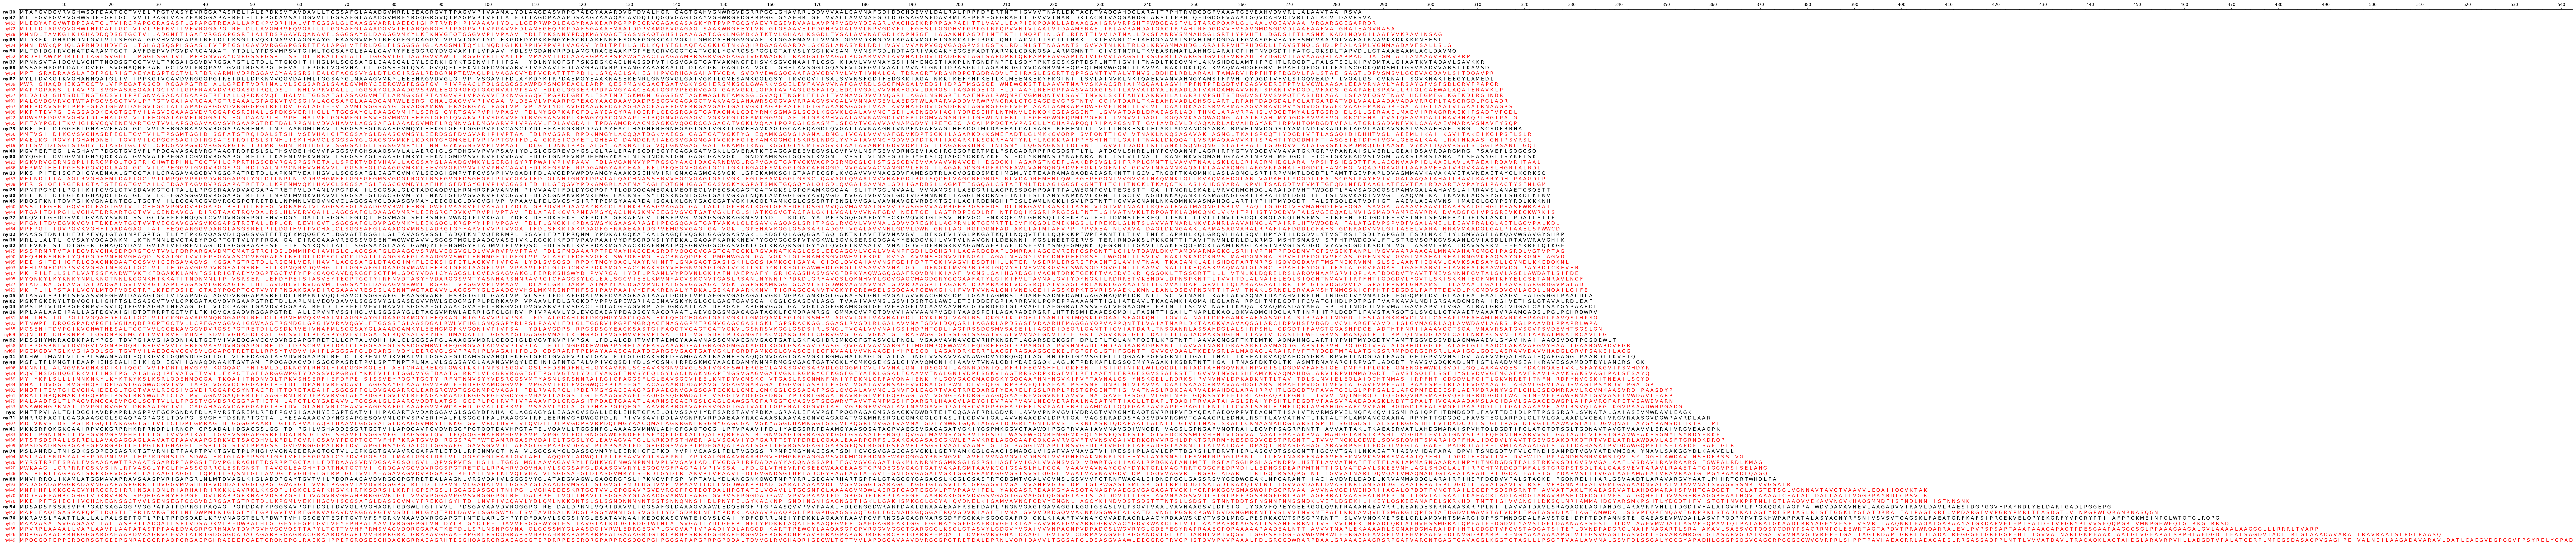

In [12]:
def sort_seqs_by_length_and_color_by_activity(fasta_file, actives, output_file):
    # Read the FASTA file
    records = list(SeqIO.parse(fasta_file, "fasta"))

    # Remove gaps from the sequences
    records = [record.__class__(record.seq.ungap("-"), id=record.id, 
                                description=record.description) for record in records]

    # Sort the sequences by length in ascending order
    records.sort(key=lambda x: len(x.seq), reverse=False)

    for i in range(len(records)):
        # Get the sequence name
        sequence_name = records[i].description.split("/")[0].lower()

        ungapped_sequence = str(records[i].seq).replace("-", "")
        alignment_length = len(ungapped_sequence)

    # Determine the longest label length
    max_label_len = max(len(record.description) for record in records)

    # Set the figure size and padding based on the label length
    fig_height = len(records) * 0.25
    fig_width = (alignment_length * 0.21 + max_label_len * 0.03)  # Adjust the padding based on label length
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=150)  # Adjust the DPI value

    # Add left padding to the plot
    pad_left = max_label_len * 0.03
    ax.set_xlim(0.5, alignment_length + 0.5)  # Adjust x-axis limits
    ax.set_ylim(-0.5, len(records) - 0.5)  # Adjust y-axis limits

    # Remove the y-axis tick marks and labels
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.NullLocator())

    # Iterate over the sequences and residues to plot the alignment
    for i, record in enumerate(records):
        sequence_name = record.description.split("/")[0].lower()

        if sequence_name in actives:
            ax.text(-pad_left, i, sequence_name, ha="right", va="center",
                    fontweight="bold", fontsize=10)
        else:
            ax.text(-pad_left, i, sequence_name, ha="right", va="center",
                    fontweight="normal", fontsize=10, c="red")

        ungapped_sequence = str(record.seq).replace("-", "")
        for j, residue in enumerate(ungapped_sequence):
            if sequence_name in actives:
                ax.text(j + 1, i, residue, ha="center", va="center", fontweight="normal",
                    fontsize=12)
            else:
                ax.text(j + 1, i, residue, ha="center", va="center", fontweight="normal",
                    fontsize=12, c="red")

    # Add minor ticks to the x-axis
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    plt.gca().invert_yaxis()
    ax.xaxis.set_ticks_position("top")
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    # Save the plot as a PNG image
    png_output_file = os.path.splitext(output_file)[0] + ".png"
    plt.savefig(png_output_file, dpi=150)  # Adjust the DPI value

    # Encode the image as base64
    with open(png_output_file, "rb") as f:
        img_data = base64.b64encode(f.read()).decode("utf-8")

    # Generate the HTML output
    html = f'<html><body><div style="position: absolute; top: 0; left: 0;"><img src="data:image/png;base64,{img_data}" /></div></body></html>'

    # Save the HTML output to a file
    with open(output_file, "w") as f:
        f.write(html)

# MAIN
fasta_file = "nylc_diversity_panel.mafft.fasta"
actives = ["nylc", "nyl4", "nyl10", "nyl11", "nyl12", "nyl13", "nyl14", "nyl15", "nyl16", "nyl18",
           "nyl25", "nyl30", "nyl32", "nyl37", "nyl40", "nyl41", "nyl45", "nyl47", "nyl48", "nyl50",
           "nyl68", "nyl71", "nyl73", "nyl74", "nyl76", "nyl77", "nyl80", "nyl82", "nyl85", "nyl87",
           "nyl88", "nyl92", "nyl94"]

output_file = "nylc_diversity_panel.sort_seqs_by_length_and_color_by_activity_20230603_jmp.html"
sort_seqs_by_length_and_color_by_activity(fasta_file, actives, output_file)
